In [1]:
import os
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.saving import load_model
from skimage.morphology import disk
from scipy.spatial import ConvexHull

In [2]:
seg_test = sorted(glob(os.path.join('.\Test\Test','*.png')))
print(len(seg_test))

648


In [3]:
test_ims = []
for i in range(len(seg_test)):
    name = seg_test[i]
    name = name.replace('_seg.png','.jpg')
    name = name.replace('.\\Test\\Test\\','./Test/Modified/')
    test_ims.append(name)
print(test_ims[:5])

['./Test/Modified/ISIC_0000006.jpg', './Test/Modified/ISIC_0000011.jpg', './Test/Modified/ISIC_0000014.jpg', './Test/Modified/ISIC_0000018.jpg', './Test/Modified/ISIC_0000022.jpg']


In [4]:
test_data = np.array([np.reshape(cv.resize(cv.imread(x,cv.IMREAD_GRAYSCALE),(512,384)),(384,512,1)) for x in test_ims])
test_masks = np.array([np.reshape(cv.resize(cv.imread(y,cv.IMREAD_GRAYSCALE),(512,384)),(384,512,1)) for y in seg_test])

In [5]:
autoencoder = load_model("autoencoder_seg.keras")
autoencoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 384, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 256, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 128, 8)        1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 64, 4)         292       
                                                                 
 conv2d_transpose (Conv2DTr  (None, 96, 128, 4)        148       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 192, 256, 8)       296       
 Transpose)                                                

In [6]:
test_masks = 1/255*test_masks

In [25]:
s = np.zeros((648,255))
m = np.concatenate((np.zeros((384,64)),np.concatenate((np.ones((384,384)),np.zeros((384,64))),axis=1)),axis=1)

for i in range(0,648,2):
    print(i)
    z = test_data[i:i+2]/255
    p = autoencoder(z).numpy()
    for k in range(2):
        mask = test_masks[i+k]
        #Area
        area = np.sum(mask)
        
        mi = np.min(p[k])
        ma = np.max(p[k])
            
        ad = 255/(ma-mi)*(p[k]-mi)
        
        for t in range(255):
            da = (ad>t).astype(np.uint8)

            s0 = np.sum(ad,axis=0)
            s1 = np.sum(s0[:128])
            s2 = np.sum(s0[128:256])
            s3 = np.sum(s0[256:384])
            if s1>s2 or s3>s2:
                da = (da.reshape(384,512)*m).astype(np.uint8)
            
            da = cv.morphologyEx(da, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (60, 45)))
            da = np.pad(da,((1,1),(1,1)),'constant',constant_values=(0,0))
            # Find largest contour in intermediate image
            cnts, _ = cv.findContours(da, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
            if len(cnts)!=0:
                cnt = max(cnts, key=cv.contourArea)
                # Output
                out = np.zeros(da.shape, np.uint8)
                cv.drawContours(out, [cnt], -1, 1, cv.FILLED)

                diff = np.abs(mask.reshape((384,512))-out[1:385,1:513])
                area_ratio = np.sum(diff)/area
                
                s[i+k,t] = area_ratio

err = np.sum(s,axis=0)
best_t = np.argmin(err)

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
456
458
460
462
464
466
468
470
472
474
476
478
480
482
484
486
488
490
492
494
496
498
500
502
504
506
508
510
512
514
516
518
520
522
524
526

In [27]:
print(best_t)

252


In [26]:
print(err)

[8260.56900394 8260.56762803 8260.55779691 8260.53244844 8260.5041494
 8260.46612345 8260.0164915  8258.54915698 8257.65972673 8256.00770302
 8254.35021484 8252.76023079 8250.65581744 8247.19831637 8243.9755157
 8237.30281431 8233.96779926 8230.08742761 8223.41605385 8216.75713938
 8202.82800227 8185.54343068 8154.96795068 8139.11121075 8123.56182773
 8106.45151807 8074.03177768 8027.98318731 7998.65453878 7957.65457716
 7895.32373457 7847.3261834  7817.06148412 7751.18726582 7712.92959701
 7664.71237509 7623.96569667 7577.62868492 7544.77713675 7510.1327863
 7471.81098676 7379.28502108 7335.63703429 7305.38349556 7262.16324814
 7209.88150931 7157.77167633 7107.01851304 7057.83694931 7005.5459898
 6957.95802896 6907.76348074 6818.54180951 6760.29815463 6687.02391341
 6610.25862027 6520.78289541 6442.58308242 6359.96515893 6295.18670358
 6172.48513236 6109.27889187 6029.71838776 5934.46205929 5853.99490685
 5789.08296073 5732.60351218 5685.16185866 5629.27957024 5559.76719336
 5515.3801

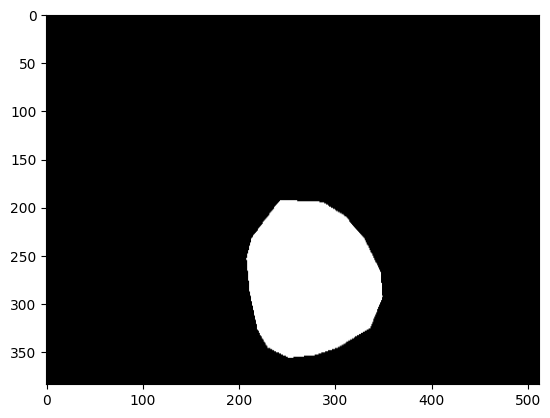

In [28]:
plt.imshow(mask,cmap='gray')

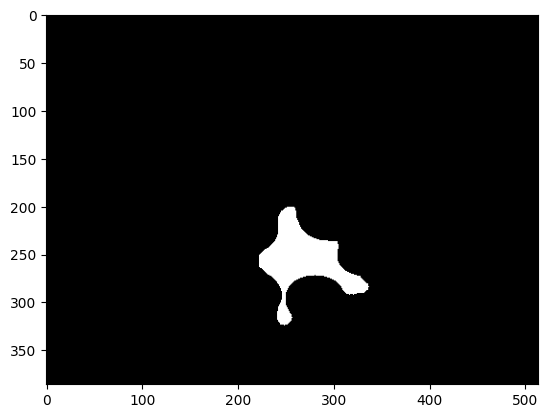

In [29]:
plt.imshow(out,cmap='gray')

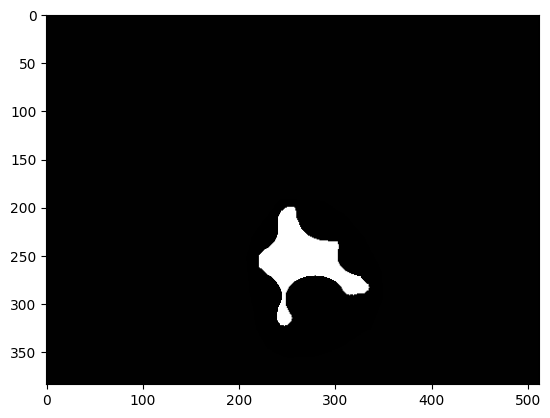

In [19]:
plt.imshow(out[1:385,1:513]-mask.reshape((384,512)),cmap='gray')